In this workflow, we will show spatial clustering and cluster analysis techniques applied to segmented nuclei from H&E WSI. Using nuclei segmentations, we identify and analyze spatial patterns of immune cell aggregates and their relationship to tissue structures. This is useful for understanding the spatial organization of immune cells in the tumor microenvironment, which can provide insights into immune response related questions such as immune activation, infiltration etc. Note that this workflow is not limited to immune cells, it can be applied to any type of spatially distributed objects, such as collagen fibers, stromal cells, etc.

Key steps include:

- Density-based clustering to identify immune cell aggregates.
- Extraction of cluster features such as size, area, dispersion, and orientation.
- Visualization of clusters and their centroids.
- Analysis of cluster proximity to different tissue types.
- Introduction to LISA-clustering (Local Indicators of Spatial Association) which is based on spatial autocorrelation.

Let's start by loading the example data.

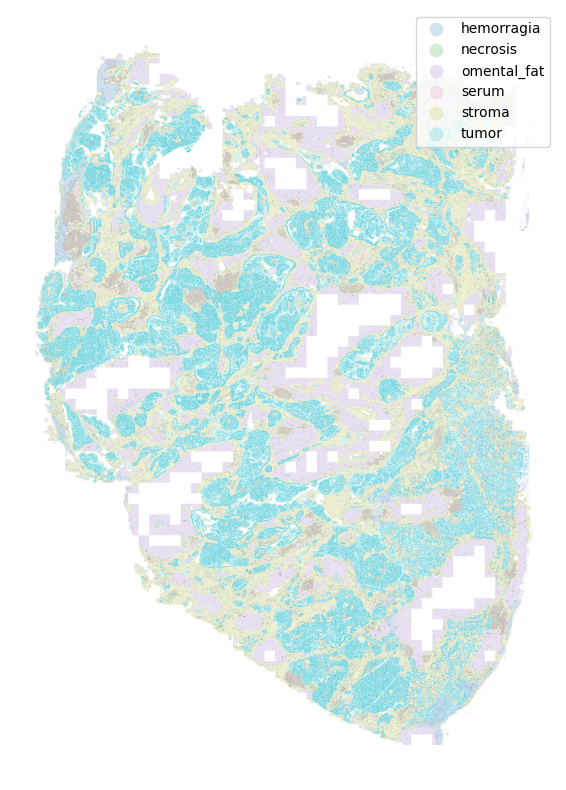

In [1]:
from histolytics.data import hgsc_nuclei_wsi, hgsc_tissue_wsi

nuc = hgsc_nuclei_wsi()
tis = hgsc_tissue_wsi()

ax = tis.plot(figsize=(10, 10), column="class_name", alpha=0.2, aspect=1, legend=True)
nuc.plot(ax=ax, column="class_name", aspect=1)
ax.set_axis_off()

## Density based clustering

We will use the dbscan algorithm to cluster the inflammatory cells that often form spatial clusters in the tissue. The dbscan algorithm is a density-based clustering algorithm that groups together points that are closely packed together, marking as outliers points that lie alone in low-density regions. This is suitable if you want to, for example, extract Tertiary Lymphoid Structures (TLS) or other lymphocyte aggregates (Lagg) from the tissue. We will use the `density_clustering`-function to this which is a wrapper around different density based clustering algorithms. The available algorithms are `dbscan`, `hdbscan` `adbscan`, and `optics`. 

At least, the following parameters should be considered:

- `method`: The algorithm to use for clustering. Options are `dbscan`, `hdbscan`, `adbscan`, and `optics`.
- `min_samples`: The minimum number of samples in a neighborhood for a point to be considered as a core point.
- `eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other.

,geometry,class_name,uid,labels
uid,,,,
86,"POLYGON ((547 37896.99179, 547 37901.98458, 55...",inflammatory,86,-1
94,"POLYGON ((700.99994 37928.98328, 705.99301 379...",inflammatory,94,-1
98,"POLYGON ((625 37499.99179, 625.99907 37511.982...",inflammatory,98,-1


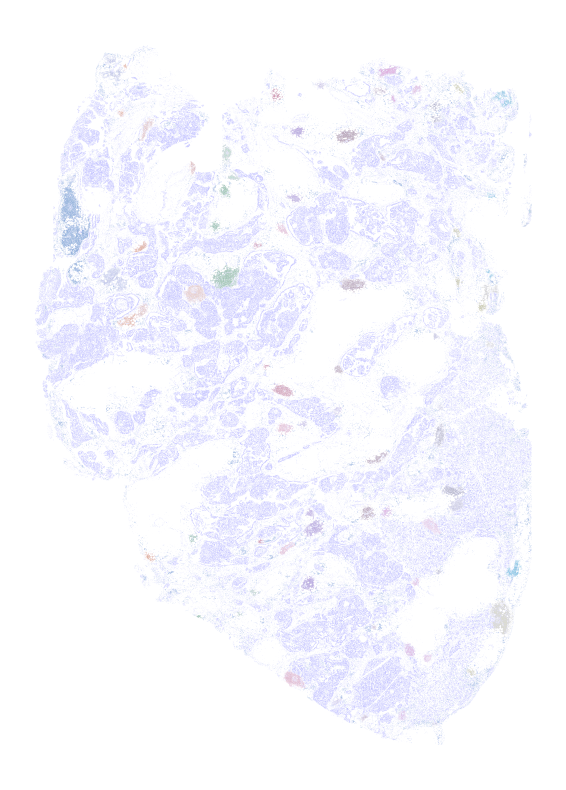

In [2]:
from histolytics.spatial_clust.density_clustering import density_clustering

nuc_imm = nuc[nuc["class_name"] == "inflammatory"]
labels = density_clustering(nuc_imm, eps=250, min_samples=100, method="dbscan")
nuc_imm = nuc_imm.assign(labels=labels)

ax = nuc.plot(figsize=(10, 10), color="blue", alpha=0.3, aspect=1)
nuc_imm.plot(ax=ax, column="labels", aspect=1, cmap="tab20")
ax.set_axis_off()
nuc_imm.head(3)

The immune cell clusters are highlighted with different colors in the image. 

### Cluster centrography analysis

Next, we will analyze these immune clusters by computing spatial centrography features. We will first get the cluster tendencies i.e. we will extract the cluster centroids. Then we will calculate the cluster size, area, dispersion and orientation for each cluster, and finally we will plot some visualizations of the clusters. We will use the `cluster_tendency`-function to extract the cluster centroids, and then the `cluster_feats`-function to compute the size, area, dispersion and orientation of the clusters.

In [ ]:
from histolytics.spatial_clust.centrography import cluster_tendency
from histolytics.spatial_clust.clust_metrics import cluster_feats
import pandas as pd
import geopandas as gpd

# compute cluster centroids and features, use groupby to apply the functions
# to each cluster separately
clust_centroids = (
    nuc_imm.groupby("labels")
    .apply(lambda g: cluster_tendency(g, "mean"), include_groups=False)
    .reset_index(drop=False, name="geometry")
)


clust_features = (
    nuc_imm.groupby("labels")
    .apply(
        lambda x: pd.Series(
            cluster_feats(x, hull_type="convex_hull", normalize_orientation=True)
        ),
        include_groups=False,
    )
    .reset_index(drop=False)
)

# merge the cluster centroids and features
clust_feats = clust_centroids.merge(clust_features, on="labels")

# convert to GeoDataFrame
clust_feats = gpd.GeoDataFrame(clust_feats, geometry="geometry")

# drop the noise cluster
clust_feats = clust_feats[clust_feats["labels"] != -1]
clust_feats

,labels,geometry,area,dispersion,size,orientation
1,0,POINT (2432.115 30375.571),3.348646e+05,210.071720,163.0,6.179748
2,1,POINT (3508.768 49500.988),1.653666e+07,1853.488920,12115.0,89.351877
3,2,POINT (3647.298 44067.835),1.130964e+06,473.763578,494.0,40.110568
4,3,POINT (4007.447 45206.207),1.262858e+06,435.069612,760.0,42.858027
5,4,POINT (3669.01 53649.081),1.303155e+05,148.194231,83.0,83.119968
...,...,...,...,...,...,...
86,85,POINT (44933.734 21806.188),3.499691e+05,238.108927,181.0,8.879143
87,86,POINT (44859.741 36651.431),1.522813e+05,157.504412,107.0,69.020168
88,87,POINT (46434.795 49237.848),2.432184e+05,203.606126,155.0,40.041491
89,88,POINT (46836.496 50458.293),3.192061e+05,232.912671,225.0,89.920405


Let's visualize clusters and cluster centroids. We will highlight the cluster area in the plot to emphasize size differences.

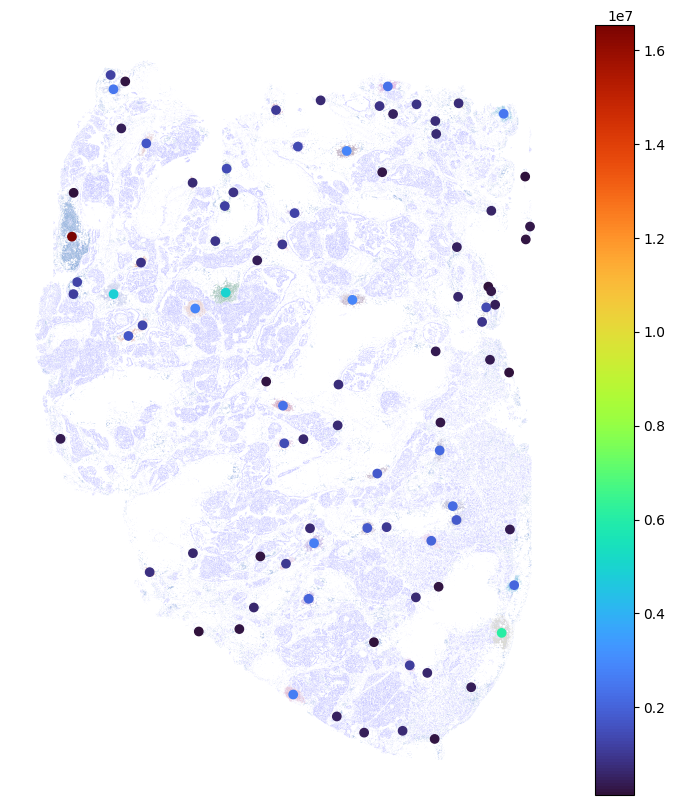

In [4]:
ax = nuc.plot(figsize=(10, 10), color="blue", alpha=0.3, aspect=1)
ax = nuc_imm.plot(ax=ax, column="labels", aspect=1, cmap="tab20")
clust_feats.plot(ax=ax, column="area", aspect=1, cmap="turbo", legend=True)
ax.set_axis_off()

### Cluster centroid distances to different tissues

Let's also calculate the distances of the cluster centroids to different tissue types. This can help in understanding how the clusters are distributed in relation to the tissue types. We use the `cluster_dists_to_tissue` function for this purpose and measure the immune cluster centroid distances to tumor and omental fat.

,labels,geometry,area,dispersion,size,orientation,dist_to_tumor,dist_to_omental_fat,closest_tissue,distance_to_tissue
1,0,POINT (2432.115 30375.571),3.348646e+05,210.071720,163.0,6.179748,470.562498,684.283538,closest_to_tumor,470.562498
2,1,POINT (3508.768 49500.988),1.653666e+07,1853.488920,12115.0,89.351877,1109.971754,27.871816,closest_to_omental_fat,27.871816
3,2,POINT (3647.298 44067.835),1.130964e+06,473.763578,494.0,40.110568,392.835962,63.166300,closest_to_omental_fat,63.166300
4,3,POINT (4007.447 45206.207),1.262858e+06,435.069612,760.0,42.858027,786.065105,0.000000,closest_to_omental_fat,0.000000
5,4,POINT (3669.01 53649.081),1.303155e+05,148.194231,83.0,83.119968,614.856618,165.603115,closest_to_omental_fat,165.603115


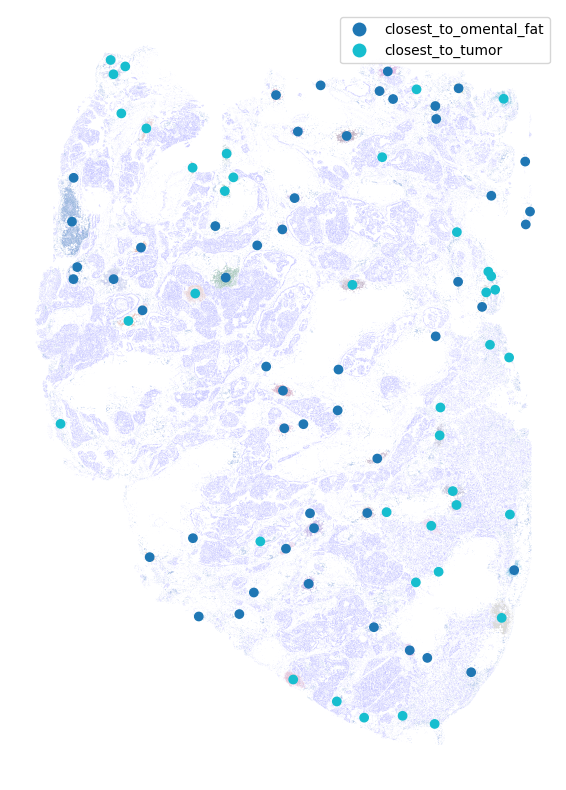

In [5]:
from histolytics.spatial_clust.clust_metrics import cluster_dists_to_tissue

# get the distances to the tissue classes
clust_feats = cluster_dists_to_tissue(clust_feats, tis, "tumor")
clust_feats = cluster_dists_to_tissue(clust_feats, tis, "omental_fat")

# get the closest tissue class
clust_feats["closest_tissue"] = (
    clust_feats[["dist_to_tumor", "dist_to_omental_fat"]]
    .idxmin(axis=1)
    .str.replace("dist_to", "closest_to")
)

# # get the distance to the closest tissue class
clust_feats["distance_to_tissue"] = clust_feats[
    ["dist_to_tumor", "dist_to_omental_fat"]
].min(axis=1)


ax = nuc.plot(figsize=(10, 10), color="blue", alpha=0.3, aspect=1)
ax = nuc_imm.plot(ax=ax, column="labels", aspect=1, cmap="tab20")
clust_feats.plot(ax=ax, column="closest_tissue", legend=True, aspect=1, cmap="tab10")
ax.set_axis_off()
clust_feats.head(5)

## Lisa Clustering

LISA clustering is a method based on spatial autocorrelation that identifies clusters of similar values in spatial data. It is particularly useful for detecting local patterns of a specific feature in spatial data, such as clusters of high or low values of immune cell density, or collagen fiber organization, or nuclear size. The feature can be anything that can be represented as a numerical value in the spatial data. In Histolytics, the `lisa_clustering` function can be used to perform LISA clustering on the segmented WSI data. The methods returns following labels: HH (High-High), LH (Low-High), HL (High-Low), LL (Low-Low), and NA (Not Applicable), where HH indicates a cluster of high values surrounded by high values, LH indicates a cluster of low values surrounded by high values, HL indicates a cluster of high values surrounded by low values, LL indicates a cluster of low values surrounded by low values, and NA indicates areas where clustering is not applicable.

In this quick example, we will first compute the immune cell count in each neighborhood which will be used as the numeric feature we compute the LISA clusters for:

<Axes: >

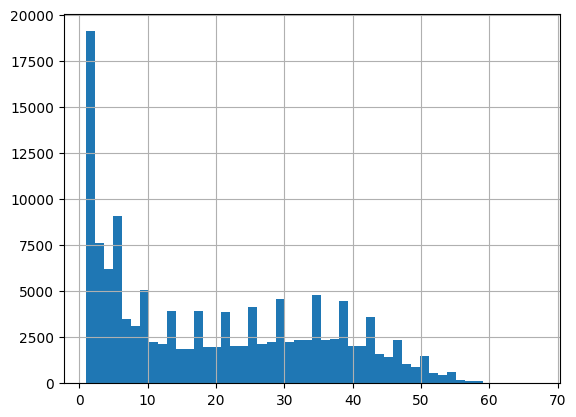

In [ ]:
from histolytics.spatial_graph.graph import fit_graph
from histolytics.spatial_agg.local_values import local_type_counts
from histolytics.utils.gdf import set_uid

gdf = nuc_imm.copy()
gdf = set_uid(gdf)

# fit a distance band graph to the nuclei
w, _ = fit_graph(
    gdf,
    method="distband",
    id_col="uid",
    threshold=100,
)
w.transform = "r"

# get the nhood immmune cell counts
gdf = local_type_counts(
    gdf,
    w,
    class_name="inflammatory",
    id_col="uid",
    frac=False,
    parallel=True,
    num_processes=4,
)

# check the distribution of the cmean shifted ounts
gdf["inflammatory_cnt"].hist(bins=50)

Next, we will compute the LISA clusters using the `lisa_clustering` function.

<Axes: >

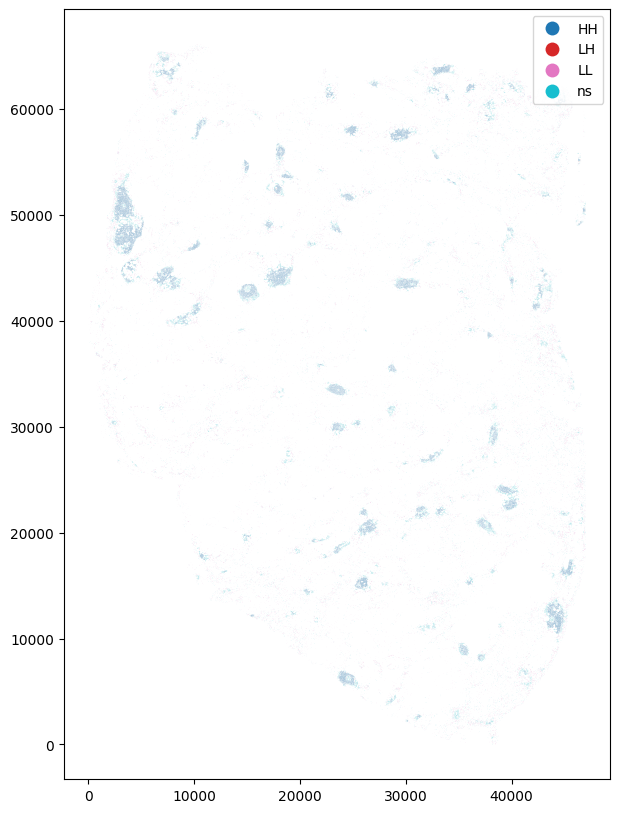

In [7]:
import warnings
from histolytics.spatial_clust.lisa_clustering import lisa_clustering

warnings.filterwarnings("ignore")

lisa_labels = lisa_clustering(gdf, w, feat="inflammatory_cnt")
gdf = gdf.assign(lisa_labels=lisa_labels)

gdf.plot(
    figsize=(10, 10),
    column="lisa_labels",
    cmap="tab10",
    legend=True,
    aspect=1,
)

In the plot, we can see mostly the LISA HH (High local immune density) -nuclei visualized on the image as the other clusters are less prominent. To make use of the LISA clusters individually, we would need to re-cluster the HH cluster with a density-based clustering algorithm to extract the connected components, however, we will let this for a future analysis.

## Conclusion
In this workflow, we have demonstrated how to perform spatial clustering and cluster analysis on segmented nuclei from H&E WSI. We used density-based clustering to identify immune cell aggregates, computed cluster features, and visualized the clusters and their centroids. Additionally, we introduced LISA clustering as a method for detecting local patterns in spatial data. These techniques can be applied to various types of spatially distributed objects in histological images, providing valuable insights into tissue organization and for example to immune response analysis.